# Acute Toxicity Models

### Load models

In [6]:
import torch
import pickle
assert torch.cuda.is_available()
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

# Load models
deepchem_models = ["acute_tox_atf.pt", "acute_tox_gcn.pt", "acute_tox_mpnn.pt"]
sklearn_models = ["acute_tox_dnn.pt"]
transformers_models = ["chemberta"]

models = []

for m in deepchem_models:
    print("Loading: ", m)
    models.append(torch.load("models/" + m))

for m in sklearn_models:
    print("Loading: ", m)
    with open(f"models/{m}", 'rb') as f:
        models.append(pickle.load(f))

for m in transformers_models:
    print("Loading: ", m)
    tokenizer = AutoTokenizer.from_pretrained(f"models/{m}")
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    model = AutoModelForSequenceClassification.from_pretrained(f"models/{m}", num_labels=5, ignore_mismatched_sizes=True)
    pipe = TextClassificationPipeline(model=model.to("cpu"), tokenizer=tokenizer, return_all_scores=True)
    models.append(pipe)

Loading:  acute_tox_atf.pt
Loading:  acute_tox_gcn.pt
Loading:  acute_tox_mpnn.pt
Loading:  acute_tox_dnn.pt
Loading:  chemberta


/scratch/rottach/miniconda3/envs/tox/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch/rottach/miniconda3/envs/tox/lib/python3.8/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.0.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/scratch/rottach/miniconda3/envs/tox/lib/python3.8/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecate

### Prepare data

In [7]:
from rdkit import Chem
import pandas as pd

# GHS Class mapping (use if needed)
def map_to_ghs_class(x):
    if x <= 5:
        return 0
    if x <= 50:
        return 1
    if x <= 300:
        return 2
    if x <= 2000:
        return 3
    else:
        return 4


# Load SDF file
supplier = Chem.SDMolSupplier('data/external_validation_data.sdf')

# Initialize lists to store molecule names and SMILES strings
molecule_labels = []
smiles_strings = []

# Iterate over molecules in the SDF file
for molecule in supplier:
    if molecule is not None:
        # Get the molecule name
        molecule_name = molecule.GetProp('GHS Class')
        molecule_labels.append(molecule_name)

        # Convert the molecule to a SMILES string
        smiles_string = Chem.MolToSmiles(molecule)
        smiles_strings.append(smiles_string)

# Create a DataFrame from the molecule names and SMILES strings
df = pd.DataFrame({
    'label': molecule_labels,
    'smiles': smiles_strings
})

# Only take subset for predictions
df = df.head(500)

df.head()

,label,smiles
0,1,CNC(=O)O/N=C(\CS(C)=O)C(C)(C)C
1,1,CC(C(=O)O)c1ccc(C(=O)c2cccs2)cc1
2,1,O=C1[C@@H]2[C@@H]3O[C@H]3[C@H]1[C@H]1[C@@H]2[C...
3,1,COP(C)(=O)SC
4,3,CC(N)[C@H]1CC[C@H](c2ccc(N)cc2)CC1


<AxesSubplot: xlabel='label', ylabel='count'>

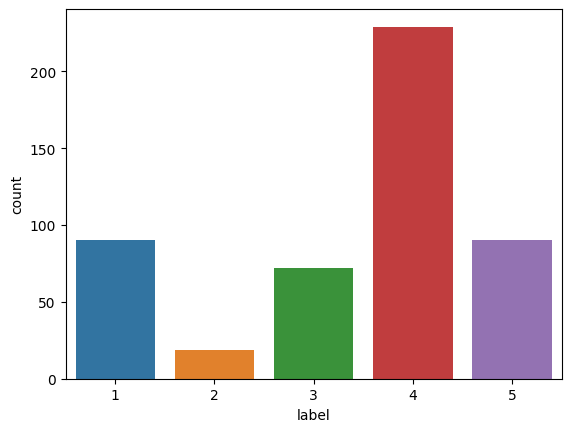

In [8]:
import seaborn as sns

sns.countplot(df.sort_values(by="label"), x="label")

### Compute Consensus prediction

In [9]:
from featurizers import GraphFeaturizer, MorganFeaturizer
from utils import stack_graph_arrays

g_featurizer = GraphFeaturizer()
m_featurizer = MorganFeaturizer()
df["Graph"] = df["smiles"].apply(g_featurizer)
df["Fingerprints"] = df["smiles"].apply(m_featurizer)
graphs = stack_graph_arrays(df)

In [50]:
import numpy as np 
from tqdm import tqdm

# Run inference on CPU
for model in models:
    if "deepchem" in str(type(model)):
        model.to("cpu")

predictions = []
for i, graph in enumerate(tqdm(graphs)):
    model_preds = []
    for model in models:   
        if "deepchem" in str(type(model)):
            payload = graph.to_dgl_graph()
            model_preds.append(model(payload)[0].detach().numpy().squeeze())
        if "transformers" in str(type(model)):
            pred = model(df["smiles"].iloc[i])[0]
            scores = np.array([s["score"] for s in pred])
            model_preds.append(scores)
        if "sklearn" in str(type(model)):
            mol = np.array(df["Fingerprints"].iloc[i]).reshape(1, -1)
            model_preds.append(model.predict_proba(mol).squeeze())     
    
    # Aggregate model predictions
    predictions.append(np.sum(model_preds, axis=0))

100%|██████████| 500/500 [02:55<00:00,  2.85it/s]


In [51]:
df["consensus_preds"] = predictions
df["pred"] = df["consensus_preds"].apply(lambda x: x.argmax())

In [52]:
df.head()

,label,smiles,Graph,Fingerprints,consensus_preds,pred
0,1,CNC(=O)O/N=C(\CS(C)=O)C(C)(C)C,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.752301442195752, 1.0661620882510283, 0.1099...",0
1,1,CC(C(=O)O)c1ccc(C(=O)c2cccs2)cc1,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0.05062324606702784, 0.08697489386245204, 3.2...",2
2,1,O=C1[C@@H]2[C@@H]3O[C@H]3[C@H]1[C@H]1[C@@H]2[C...,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.6601844826621475, 0.7743181880374013, 2.416...",2
3,1,COP(C)(=O)SC,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.1555210541931296, 1.5926910618200782, 1.570...",1
4,3,CC(N)[C@H]1CC[C@H](c2ccc(N)cc2)CC1,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.007757664062422197, 0.15515103047451687, 1....",3


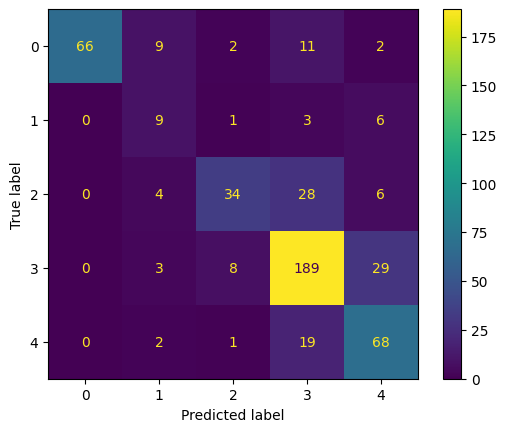

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df["label"].astype(int) - 1, df["pred"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()